# Exploring Dandiset 000563: Visual System Temporal Barcodes in Mouse Cortex

*Note: This notebook was generated with AI assistance. Users should independently verify all code and results.*

## Overview
This notebook introduces the Allen Institute Openscope - Barcoding dataset ([DANDI:000563](https://dandiarchive.org/dandiset/000563/0.250311.2145)), which investigates the temporal precision of neuronal responses to repeated visual stimuli in the mouse visual system. The dataset contains Neuropixels recordings synchronized with visual stimulation, running behavior, eye tracking, and optogenetic manipulation.

### Notebook Contents
1. Loading and examining NWB file structure
2. Exploring spike-sorted neural data
3. Understanding stimulus presentation structure
4. Accessing behavioral measurements
5. Examples of data alignment and visualization

## Required Packages

In [1]:
import h5py
import pynwb
import remfile
from dandi.dandiapi import DandiAPIClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading Data from DANDI Archive
We'll examine a representative session file using the DANDI API:

In [2]:
# Initialize DANDI client
client = DandiAPIClient()
dandiset = client.get_dandiset("000563", "0.250311.2145")

# List NWB files in dandiset
assets = list(dandiset.get_assets_by_glob("*.nwb"))

# Compile file info, focusing on main data files (*_ogen.nwb)
file_list = []
for asset in assets:
    file_info = {
        'path': asset.path,
        'size_gb': round(asset.size / 1e9, 2)
    }
    file_list.append(file_info)

ogen_files = [f for f in file_list if 'ogen' in f['path']]

print(f"Total NWB files: {len(file_list)}\n")
print("Files containing main data ('ogen'):")
for f in ogen_files:
    print(f"- {f['path']} ({f['size_gb']} GB)")

Total NWB files: 94

Files containing main data ('ogen'):
- sub-699241/sub-699241_ses-1318772854_ogen.nwb (2.83 GB)
- sub-699846/sub-699846_ses-1314466742_ogen.nwb (2.99 GB)
- sub-698259/sub-698259_ses-1314229564_ogen.nwb (4.72 GB)
- sub-692990/sub-692990_ses-1310924284_ogen.nwb (3.06 GB)
- sub-697302/sub-697302_ses-1309845146_ogen.nwb (2.97 GB)
- sub-697303/sub-697303_ses-1309536438_ogen.nwb (3.08 GB)
- sub-692360/sub-692360_ses-1301730660_ogen.nwb (3.16 GB)
- sub-692991/sub-692991_ses-1308221984_ogen.nwb (2.74 GB)
- sub-692984/sub-692984_ses-1303229472_ogen.nwb (2.98 GB)
- sub-685263/sub-685263_ses-1292234897_ogen.nwb (2.56 GB)
- sub-682745/sub-682745_ses-1290822286_ogen.nwb (3.24 GB)
- sub-681446/sub-681446_ses-1290510496_ogen.nwb (2.5 GB)
- sub-691524/sub-691524_ses-1298257492_ogen.nwb (2.71 GB)
- sub-688546/sub-688546_ses-1295360519_ogen.nwb (3.05 GB)


## Loading a Sample Session
We'll examine one session in detail:

In [3]:
# Load a specific session file
asset_path = "sub-699241/sub-699241_ses-1318772854_ogen.nwb"
asset = next(dandiset.get_assets_by_glob(asset_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Extract key metadata
meta = {
    'session_id': nwb.session_id,
    'subject_id': nwb.subject.subject_id,
    'species': nwb.subject.species,
    'age': nwb.subject.age,
    'sex': nwb.subject.sex,
    'genotype': nwb.subject.genotype,
    'date': str(nwb.session_start_time.date())
}

for k,v in meta.items():
    print(f"{k}: {v}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


session_id: 1318772854
subject_id: 699241
species: Mus musculus
age: P124D
sex: M
genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
date: 2023-12-19


## Examining Stimulus Structure
The RepeatFFF stimulus presentations are precisely timed intervals for studying temporal response precision:

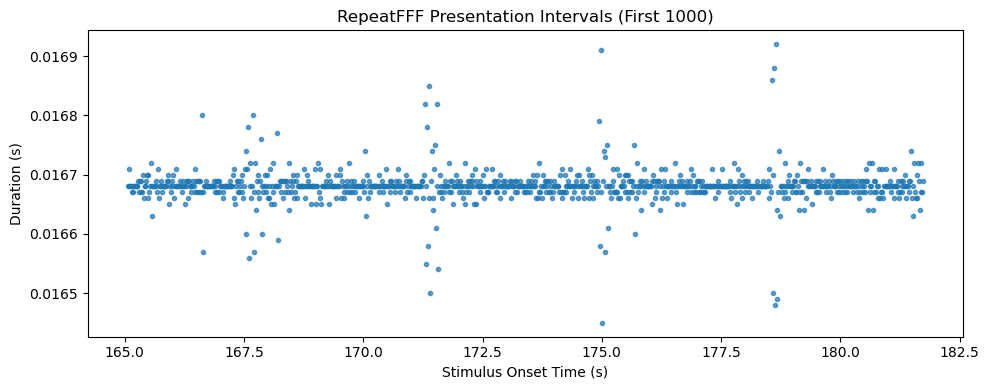


Sample of stimulus properties:
    contrast  orientation spatial_frequency            size       phase units
id                                                                           
0        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]  [0.0, 0.0]   deg
1        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]  [0.0, 0.0]   deg
2        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]  [0.0, 0.0]   deg
3        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]  [0.0, 0.0]   deg
4        1.0          0.0        [0.0, 0.0]  [250.0, 250.0]  [0.0, 0.0]   deg


In [4]:
# Get RepeatFFF interval table and examine timing
repeatfff_df = nwb.intervals['RepeatFFF_presentations'].to_dataframe()
onsets = repeatfff_df['start_time'].values[:1000]
durations = (repeatfff_df['stop_time'] - repeatfff_df['start_time']).values[:1000]

plt.figure(figsize=(10, 4))
plt.plot(onsets, durations, '.', alpha=0.7)
plt.xlabel('Stimulus Onset Time (s)')
plt.ylabel('Duration (s)')
plt.title('RepeatFFF Presentation Intervals (First 1000)')
plt.tight_layout()
plt.show()

print('\nSample of stimulus properties:')
properties = ['contrast', 'orientation', 'spatial_frequency', 'size', 'phase', 'units']
print(repeatfff_df[properties].head())

## Neural Data Access and Visualization
Here we demonstrate how to access spike times and visualize responses:

Total units: 2299
Good units: 1892


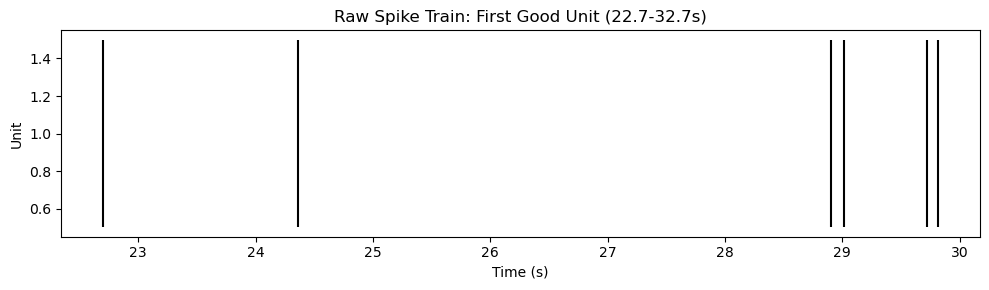

In [5]:
# Get unit qualities and find good units
unit_qualities = nwb.units['quality'][:]
good_idxs = [i for i, q in enumerate(unit_qualities) if q == 'good']
print(f"Total units: {len(unit_qualities)}")
print(f"Good units: {len(good_idxs)}")

# Get spike times for first good unit and align to stimulus
unit_idx = good_idxs[0]
spike_times = nwb.units.spike_times_index[unit_idx]

# Find earliest spike and plot window
t_start = spike_times.min()
t_stop = t_start + 10  # 10s window

plt.figure(figsize=(10, 3))
plt.vlines(spike_times[(spike_times >= t_start) & (spike_times < t_stop)], 
          0.5, 1.5, color='k')
plt.xlabel('Time (s)')
plt.ylabel('Unit')
plt.title(f'Raw Spike Train: First Good Unit ({t_start:.1f}-{t_stop:.1f}s)')
plt.tight_layout()
plt.show()

## Behavioral Data
The dataset includes running speed and eye tracking measurements:

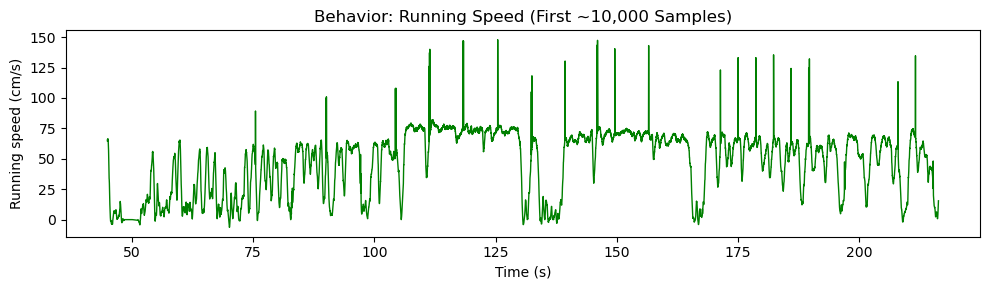

In [6]:
# Access running speed time series
ts_running = nwb.processing['running'].data_interfaces['running_speed']
running_speed = ts_running.data[:10000]  # first 10k samples
running_time = ts_running.timestamps[:10000]

plt.figure(figsize=(10, 3))
plt.plot(running_time, running_speed, color='green', lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Running speed (cm/s)')
plt.title('Behavior: Running Speed (First ~10,000 Samples)')
plt.tight_layout()
plt.show()

## Optogenetic Stimulation Events
The dataset includes optogenetic manipulation epochs:

In [7]:
# Get optogenetic stimulation intervals
opto_df = nwb.processing['optotagging'].data_interfaces['optogenetic_stimulation'].to_dataframe()
print('First 5 optogenetic stimulation intervals:')
print(opto_df[['start_time', 'stop_time', 'level', 'stimulus_name']].head())

First 5 optogenetic stimulation intervals:
    start_time   stop_time  level      stimulus_name
id                                                  
0   7270.95571  7271.95571   1.94   5 hz pulse train
1   7273.09679  7274.09679   1.94      raised_cosine
2   7275.06681  7276.06681   2.05      raised_cosine
3   7276.87680  7277.87680   1.94   5 hz pulse train
4   7278.99756  7279.99756   2.05  40 hz pulse train


## Summary and Next Steps

This notebook demonstrated how to:
- Access and examine NWB file structure
- Extract stimulus presentation timing and parameters
- Access spike times from sorted units
- Load behavioral and optogenetic data

### Suggested Analyses
- Quantify spike timing precision across repeated trials
- Relate neural responses to behavioral state
- Examine effects of optogenetic manipulation
- Compare responses across visual areas

### Key Resources
- [DANDI Archive](https://www.dandiarchive.org/)
- [NWB Format](https://www.nwb.org/)
- [NeuroSIFT Viewer](https://neurosift.app/nwb?dandisetId=000563&dandisetVersion=0.250311.2145)